In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ravidussilva/real-ai-art

100% 9.95G/9.95G [02:01<00:00, 43.8MB/s]
100% 9.95G/9.95G [02:01<00:00, 88.2MB/s]


In [5]:
!unzip real-ai-art.zip

Streaming output truncated to the last 5000 lines.
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_114.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_116.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_142.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_154.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_183.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_186.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_201.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_219.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_230.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_274.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_279.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_286.jpg  
  inflating: Real_AI_SD_LD_Dataset/train/ukiyo_e/adachi-ginko_3.jpg  
  inflating: Re

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image

class AIArtBenchDataset(Dataset):
    def __init__(self, root, for_training=True, transforms=None, target_transforms=None):
        self.for_training = for_training
        self.transforms = transforms
        self.target_transforms = target_transforms

        if self.for_training:
            self.root = os.path.join(root, 'train')
        else:
            self.root = os.path.join(root, 'test')

        self.fnames_list = []
        for directory in os.listdir(self.root):
            for image in os.listdir(os.path.join(self.root, directory)):
                self.fnames_list.append(os.path.join(directory, image))

    def __len__(self):
        return len(self.fnames_list)

    def __getitem__(self, idx):
        img_name = self.fnames_list[idx]
        img_path = os.path.join(self.root, img_name)
        image = read_image(img_path)

        if 'AI' in img_name:
            if 'SD' in img_name:
                label = 0 # 0 for standard diffusion art
            else:
                label = 1 # 1 for latent diffusion art
        else:
            label = 2 # 2 for real art

        if self.transforms:
            image = self.transforms(image)
        if self.target_transforms:
            label = self.target_transforms(label)

        return image, label

In [7]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00


In [8]:
import numpy as np
import random
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, Compose, ToTensor, Lambda
import torchvision.transforms.functional as F

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming AIArtBenchDataset is a custom dataset class
train_dataset = AIArtBenchDataset(root='/content/Real_AI_SD_LD_Dataset', for_training=True, transforms=transform)

# Set seed for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
from torchvision.models import resnet50
import torch.nn as nn

class MyResNet(nn.Module):
    def __init__(self, num_classes, is_pretrained=False):
        super(MyResNet, self).__init__()

        # Instantiate a pretrained/randomly-initialized resnet model
        self.resnet_model = resnet50(pretrained=is_pretrained)

        # Modify last layer to map to 3 output classes
        in_features = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet_model(x)

In [15]:
import numpy as np
import random
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import Resize, Normalize, Compose, ToTensor, Lambda
import torchvision.transforms.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyResNet(num_classes=3, is_pretrained=False).to(device)

# Define loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

transform = transforms.Compose([
    Lambda(lambda x: x.float()),  # Convert images to float tensors
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming AIArtBenchDataset is a custom dataset class
train_dataset = AIArtBenchDataset(root='/content/Real_AI_SD_LD_Dataset', for_training=True, transforms=transform)

# Set seed for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
import time
from tqdm import tqdm  # Import tqdm for the progress bar

# Lists to store training and validation metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    # Training phase with tqdm for progress bar
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as train_bar:
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total

    # Store training metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # Validation phase with tqdm for progress bar
        with tqdm(val_dataloader, desc='Validation', unit='batch') as val_bar:
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                val_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total

    # Store validation metrics
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'resnet_model.pth')

Epoch 1/5:   0%|          | 0/3876 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 1/5:   0%|          | 0/3876 [00:09<?, ?batch/s]


KeyboardInterrupt: ignored

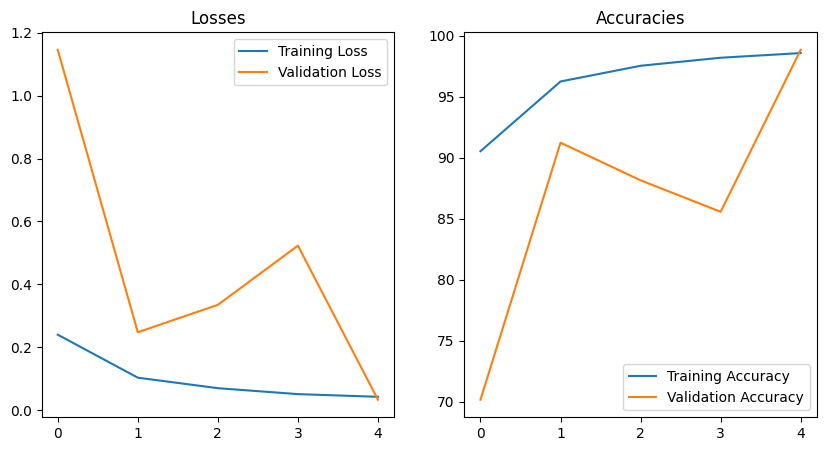

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracies')
plt.legend()

plt.show()

In [16]:
# Code to load pre-trained model from .pth file
model.load_state_dict(torch.load('resnet_model.pth'))

<All keys matched successfully>

In [17]:
from tqdm import tqdm  # Import tqdm for the progress bar

test_dataset = AIArtBenchDataset(root='/content/Real_AI_SD_LD_Dataset', for_training=False, transforms=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
test_predictions = []
true_labels = []

with torch.no_grad():
    # Test phase with tqdm for progress bar
    with tqdm(test_dataloader, desc='Testing', unit='batch') as test_bar:
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            test_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * correct / total

print(f'\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Testing: 100%|██████████| 938/938 [04:02<00:00,  3.86batch/s, accuracy=98.8, loss=0.168]


Test Loss: 0.0343, Test Accuracy: 98.77%


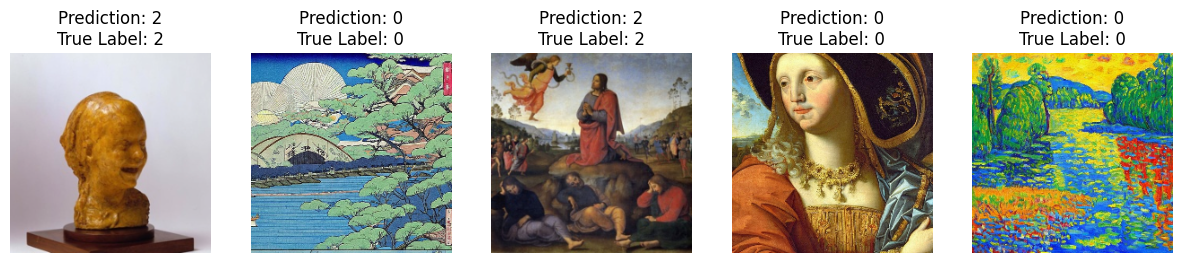

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms.functional as F

# Function to display images with predictions and true labels
def display_images(images, predictions, true_labels, class_labels):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        # Convert PIL image to ndarray
        img_array = np.array(images[i])

        plt.subplot(1, 5, i + 1)
        plt.imshow(np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.title(f"Prediction: {class_labels[predictions[i].item()]}\nTrue Label: {class_labels[true_labels[i].item()]}")
        plt.axis('off')
    plt.show()

# Choose 5 random samples from the test set
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Convert predictions and true labels to NumPy arrays for indexing
sample_predictions = np.array(test_predictions)[sample_indices]
sample_true_labels = np.array(true_labels)[sample_indices]

# Display the images with predictions and true labels
display_images(sample_images, sample_predictions, sample_true_labels, class_labels=["0", "1", "2"])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_f

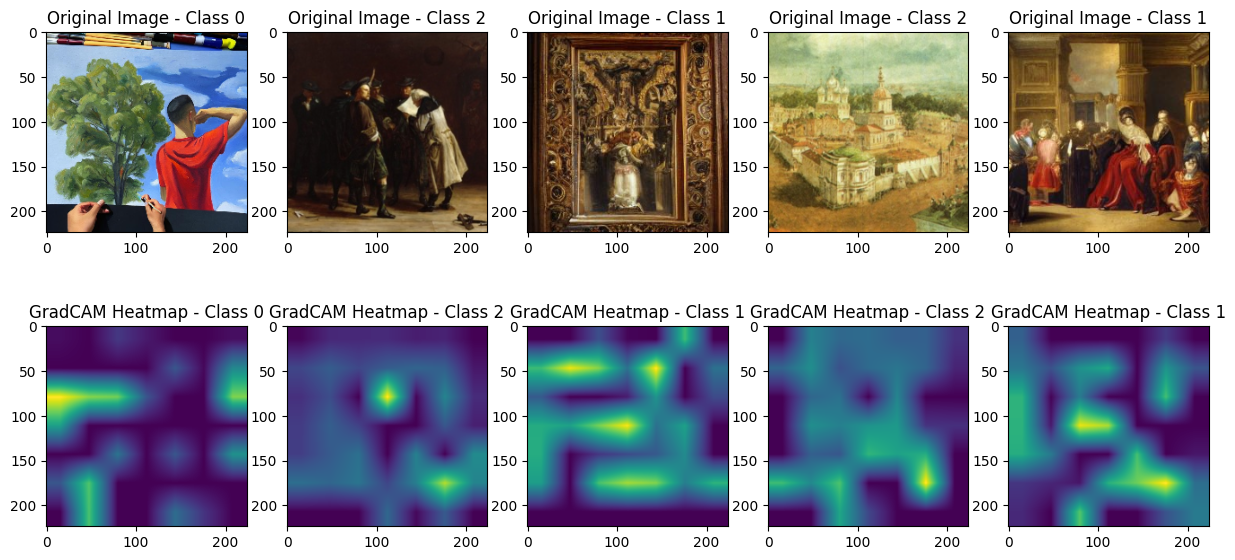

In [28]:
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Function

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()
        self.feature_maps = None
        self.gradient = None
        self.hooks = []

        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            self.feature_maps = output.detach()

        self.hooks.append(self.target_layer.register_forward_hook(hook_fn))

        def backward_hook_fn(module, grad_input, grad_output):
            self.gradient = grad_output[0].detach()

        self.hooks.append(self.target_layer.register_backward_hook(backward_hook_fn))

    def forward(self, x):
        return self.model(x)

    def backward(self, output, target_class):
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1.0
        output.backward(gradient=one_hot_output, retain_graph=True)

    def generate(self, input_image, target_class, size=(224, 224)):
        input_image = input_image.unsqueeze(0)
        output = self.forward(input_image)

        self.backward(output, target_class)

        weights = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)

        cam = torch.nn.functional.interpolate(cam, size=size, mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        return cam

# Sample indices and images
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Initialize GradCAM
gradcam = GradCAM(model, target_layer=model.resnet_model.layer4[-1].conv1)

# Plot original image and GradCAM heatmap
plt.figure(figsize=(15, 7))

for i in range(5):
    # Original Image
    plt.subplot(2, 5, i + 1)
    img_array = np.array(sample_images[i])
    plt.imshow(np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.title(f'Original Image - Class {sample_labels[i]}')

    # GradCAM Heatmap
    plt.subplot(2, 5, i + 6)
    label = sample_labels[i]  # Assuming the label is set correctly
    heatmap = gradcam.generate(sample_images[i].to(device), target_class=label)
    plt.imshow(heatmap, cmap='viridis')
    plt.title(f'GradCAM Heatmap - Class {label}')

plt.show()

[18044, 28740, 23549]


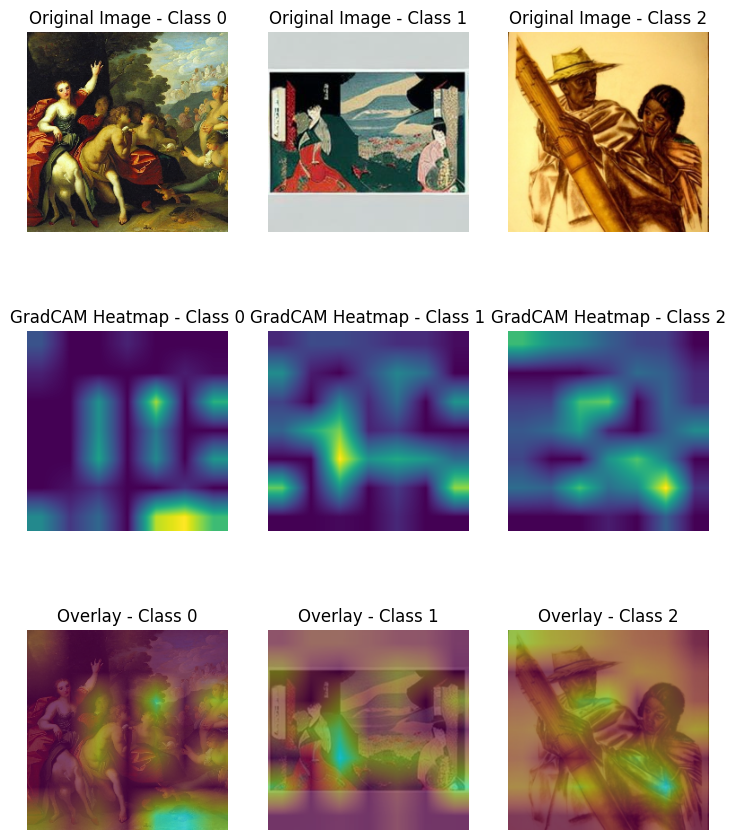

In [35]:
# Function to overlay GradCAM heatmap on the original image
def overlay_heatmap(original_img, heatmap):
    # Normalize heatmap values
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

    # Apply colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)

    # Convert original image to uint8 if it's not already
    original_img = (original_img.numpy()*255).astype(np.uint8)
    # original_img = np.transpose(original_img, (1, 2, 0))
    # print(heatmap.shape)
    # print(original_img.shape)
    # Overlay images
    overlaid_img = cv2.addWeighted(original_img, 0.25, heatmap, 0.75, 0)

    return overlaid_img


# Sample indices and images
sample_indices = [18044,28740,23549]
print(sample_indices)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Initialize GradCAM
gradcam = GradCAM(model, target_layer=model.resnet_model.layer4[-1].conv1)

# Plot original image and GradCAM heatmap
plt.figure(figsize=(15, 11))

for i in range(3):
    # Original Image
    plt.subplot(3, 5, i + 1)
    img_array = np.array(sample_images[i])
    img = np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0))
    plt.axis('off')
    plt.imshow(img)
    plt.title(f'Original Image - Class {sample_labels[i]}')

    # GradCAM Heatmap
    plt.subplot(3, 5, i + 6)
    label = sample_labels[i]  # Assuming the label is set correctly
    heatmap = gradcam.generate(sample_images[i].to(device), target_class=label)
    plt.axis('off')
    plt.imshow(heatmap, cmap='viridis')
    plt.title(f'GradCAM Heatmap - Class {label}')

    # Overlay
    plt.subplot(3, 5, i + 11)
    overlaid_img = overlay_heatmap(img, heatmap)
    plt.axis('off')
    plt.imshow(overlaid_img)
    plt.title(f'Overlay - Class {label}')

plt.show()

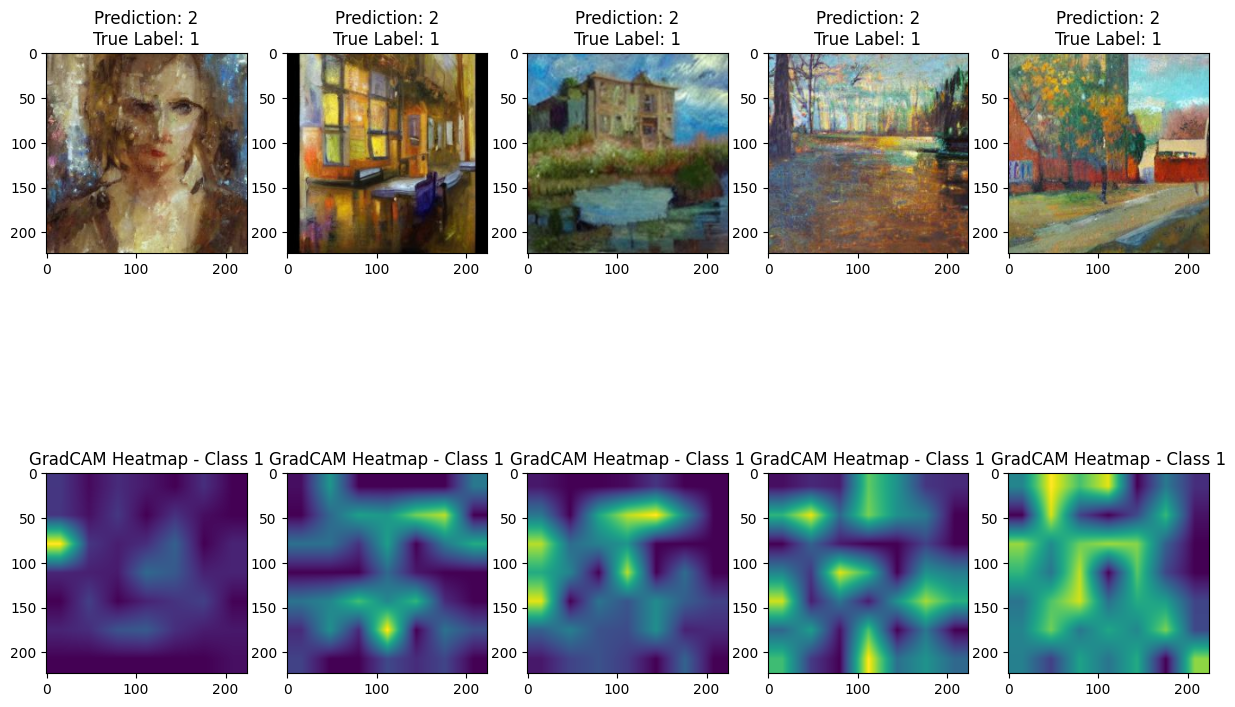

In [36]:
# Identify Misclassified Images
misclassified_indices = [i for i, (pred, true) in enumerate(zip(test_predictions, true_labels)) if pred != true]
misclassified_images = [test_dataset[i][0] for i in misclassified_indices]
misclassified_predictions = [test_predictions[i] for i in misclassified_indices]
misclassified_true_labels = [true_labels[i] for i in misclassified_indices]

# Display Misclassified Images with Predictions, True Labels, and Heatmaps
def display_misclassified_images_with_heatmaps(images, predictions, true_labels, class_labels):
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(images):
        image_index = i % 5 + 1  # This ensures the index is between 1 and 5
        heatmap_index = image_index + 5  # This places the heatmap in the second row
        # Original Image
        plt.subplot(2, 5, image_index)
        img_array = np.array(image)
        plt.imshow(np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.title(f"Prediction: {class_labels[predictions[i]]}\nTrue Label: {class_labels[true_labels[i]]}")

        # GradCAM Heatmap
        plt.subplot(2, 5, heatmap_index)

        label = true_labels[i]  # Use true label for GradCAM
        heatmap = gradcam.generate(image.to(device), target_class=label)
        plt.imshow(heatmap, cmap='viridis')
        plt.title(f'GradCAM Heatmap - Class {class_labels[label]}')


    plt.show()

# Display the misclassified images with their heatmaps
display_misclassified_images_with_heatmaps(misclassified_images, misclassified_predictions, misclassified_true_labels, class_labels=["0", "1", "2"])


<ipython-input-37-7733e4a9b131>:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 5, overlay_index)
<ipython-input-37-7733e4a9b131>:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, heatmap_index)


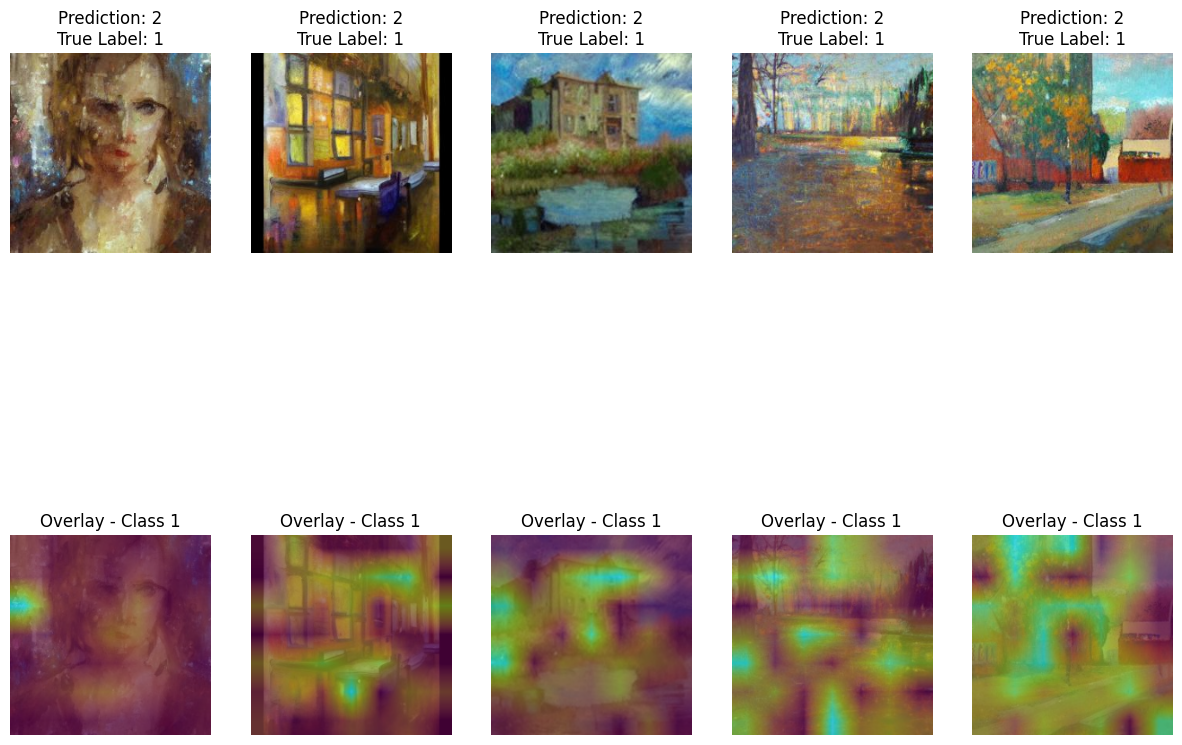

In [37]:
# Identify Misclassified Images
misclassified_indices = [i for i, (pred, true) in enumerate(zip(test_predictions, true_labels)) if pred != true]
misclassified_images = [test_dataset[i][0] for i in misclassified_indices]
misclassified_predictions = [test_predictions[i] for i in misclassified_indices]
misclassified_true_labels = [true_labels[i] for i in misclassified_indices]

# Display Misclassified Images with Predictions, True Labels, and Heatmaps
def display_misclassified_images_with_heatmaps(images, predictions, true_labels, class_labels):
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(images):
        image_index = i % 5 + 1  # This ensures the index is between 1 and 5
        heatmap_index = image_index + 5  # This places the heatmap in the second row
        overlay_index = heatmap_index + 5  # This places the overlay in the third row

        # Original Image
        plt.subplot(2, 5, image_index)
        img_array = np.array(image)
        img = np.transpose(vutils.make_grid(torch.tensor(img_array), padding=2, normalize=True).cpu(), (1, 2, 0))
        plt.axis('off')
        plt.imshow(img)
        plt.title(f"Prediction: {class_labels[predictions[i]]}\nTrue Label: {class_labels[true_labels[i]]}")

        # GradCAM Heatmap
        plt.subplot(2, 5, heatmap_index)

        label = true_labels[i]  # Use true label for GradCAM
        heatmap = gradcam.generate(image.to(device), target_class=label)
        plt.imshow(heatmap, cmap='viridis')
        plt.axis('off')
        plt.title(f'GradCAM Heatmap')

        plt.subplot(3, 5, overlay_index)
        overlaid_img = overlay_heatmap(img, heatmap)
        plt.axis('off')
        plt.imshow(overlaid_img)
        plt.title(f'Overlay - Class {label}')


    plt.show()

# Display the misclassified images with their heatmaps
display_misclassified_images_with_heatmaps(misclassified_images, misclassified_predictions, misclassified_true_labels, class_labels=["0", "1", "2"])